### loading the data -> data visualization -> train test split
### -> model building -> training -> evaluation 

### N-Gram

**please turn your page**

* **Unigram:** please | turn | your | page
* **Bigram:** please turn | turn your | your page
* **Trigram:** please turn your | turn your page

You can think of an N-gram as the sequence of N words. By that notion, a **2-gram (or bigram)** is a two-word sequence of words like "**please turn**", "**turn your**", or "**your page**", and a **3-gram (or trigram)** is a three-word sequence of words like "**please turn your**", or "**turn your page**".

---

### Bag of Words (BoW)

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval.

`x = ['which book is this', 'this is book and this is math']`

| Index | and | book | is | math | this | which |
|:-----:|:---:|:----:|:--:|:----:|:----:|:-----:|
|   0   |  0  |  1   | 1  |  0   |  1   |   1   |
|   1   |  1  |  1   | 2  |  1   |  2   |   0   |



### Term Frequency (TF)

Term frequency is simply the ratio of the count of a word present in a sentence to the length of the sentence.

`x = ['which book is this', 'this is book and this is math']`

| Index | and     | book    | is      | math    | this    | which   |
|:-----:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|
|   0   | 0.00000 | 0.25000 | 0.25000 | 0.00000 | 0.25000 | 0.25000 |
|   1   | 0.14286 | 0.14286 | 0.28571 | 0.14286 | 0.28571 | 0.00000 |


##### 'this' word has two presence in the second part which is 'this is book and this is math' having 7 words in total 
#####  thereby 2 divided by 7 (0.2857142857142857)

### Inverse Document Frequency (IDF)

IDF is used to evaluate how important a word is in the entire corpus. It is calculated using the formula:

```
idf = log((1 + N) / (n + 1)) + 1
```

> Used in `sklearn` when `smooth_idf = True`  
> `log` refers to the natural logarithm (base **e**)

- **N** = Total number of documents (rows)  
- **n** = Number of documents in which the word appears

The more frequently a word appears across multiple documents, the lower its IDF — implying it's less unique or informative.

---

### TF-IDF

- **Term Frequency (TF):** Measures how frequently a term appears in a document.
- **Inverse Document Frequency (IDF):** Reduces the weight of common terms and increases the weight of rare ones.

Combined, they form:

```
TF-IDF = TF * IDF
```


### Load the dataset

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [119]:
df  = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/spam.tsv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
 2   length   5572 non-null   int64 
 3   punct    5572 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.3+ KB


In [121]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [122]:
df.shape

(5572, 4)

In [123]:
df['label'].value_counts()


label
ham     4825
spam     747
Name: count, dtype: int64

In [124]:
def plot_value_counts(df, column_name, color_palette='viridis'):
    value_counts = df[column_name].value_counts()  

    plt.figure(figsize=(12, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette=color_palette)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Distribution of {column_name}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [125]:
import seaborn as sns

/var/folders/zp/cw6162y95ynbbzgy5bwjwtp80000gn/T/ipykernel_51082/1161364916.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette=color_palette)


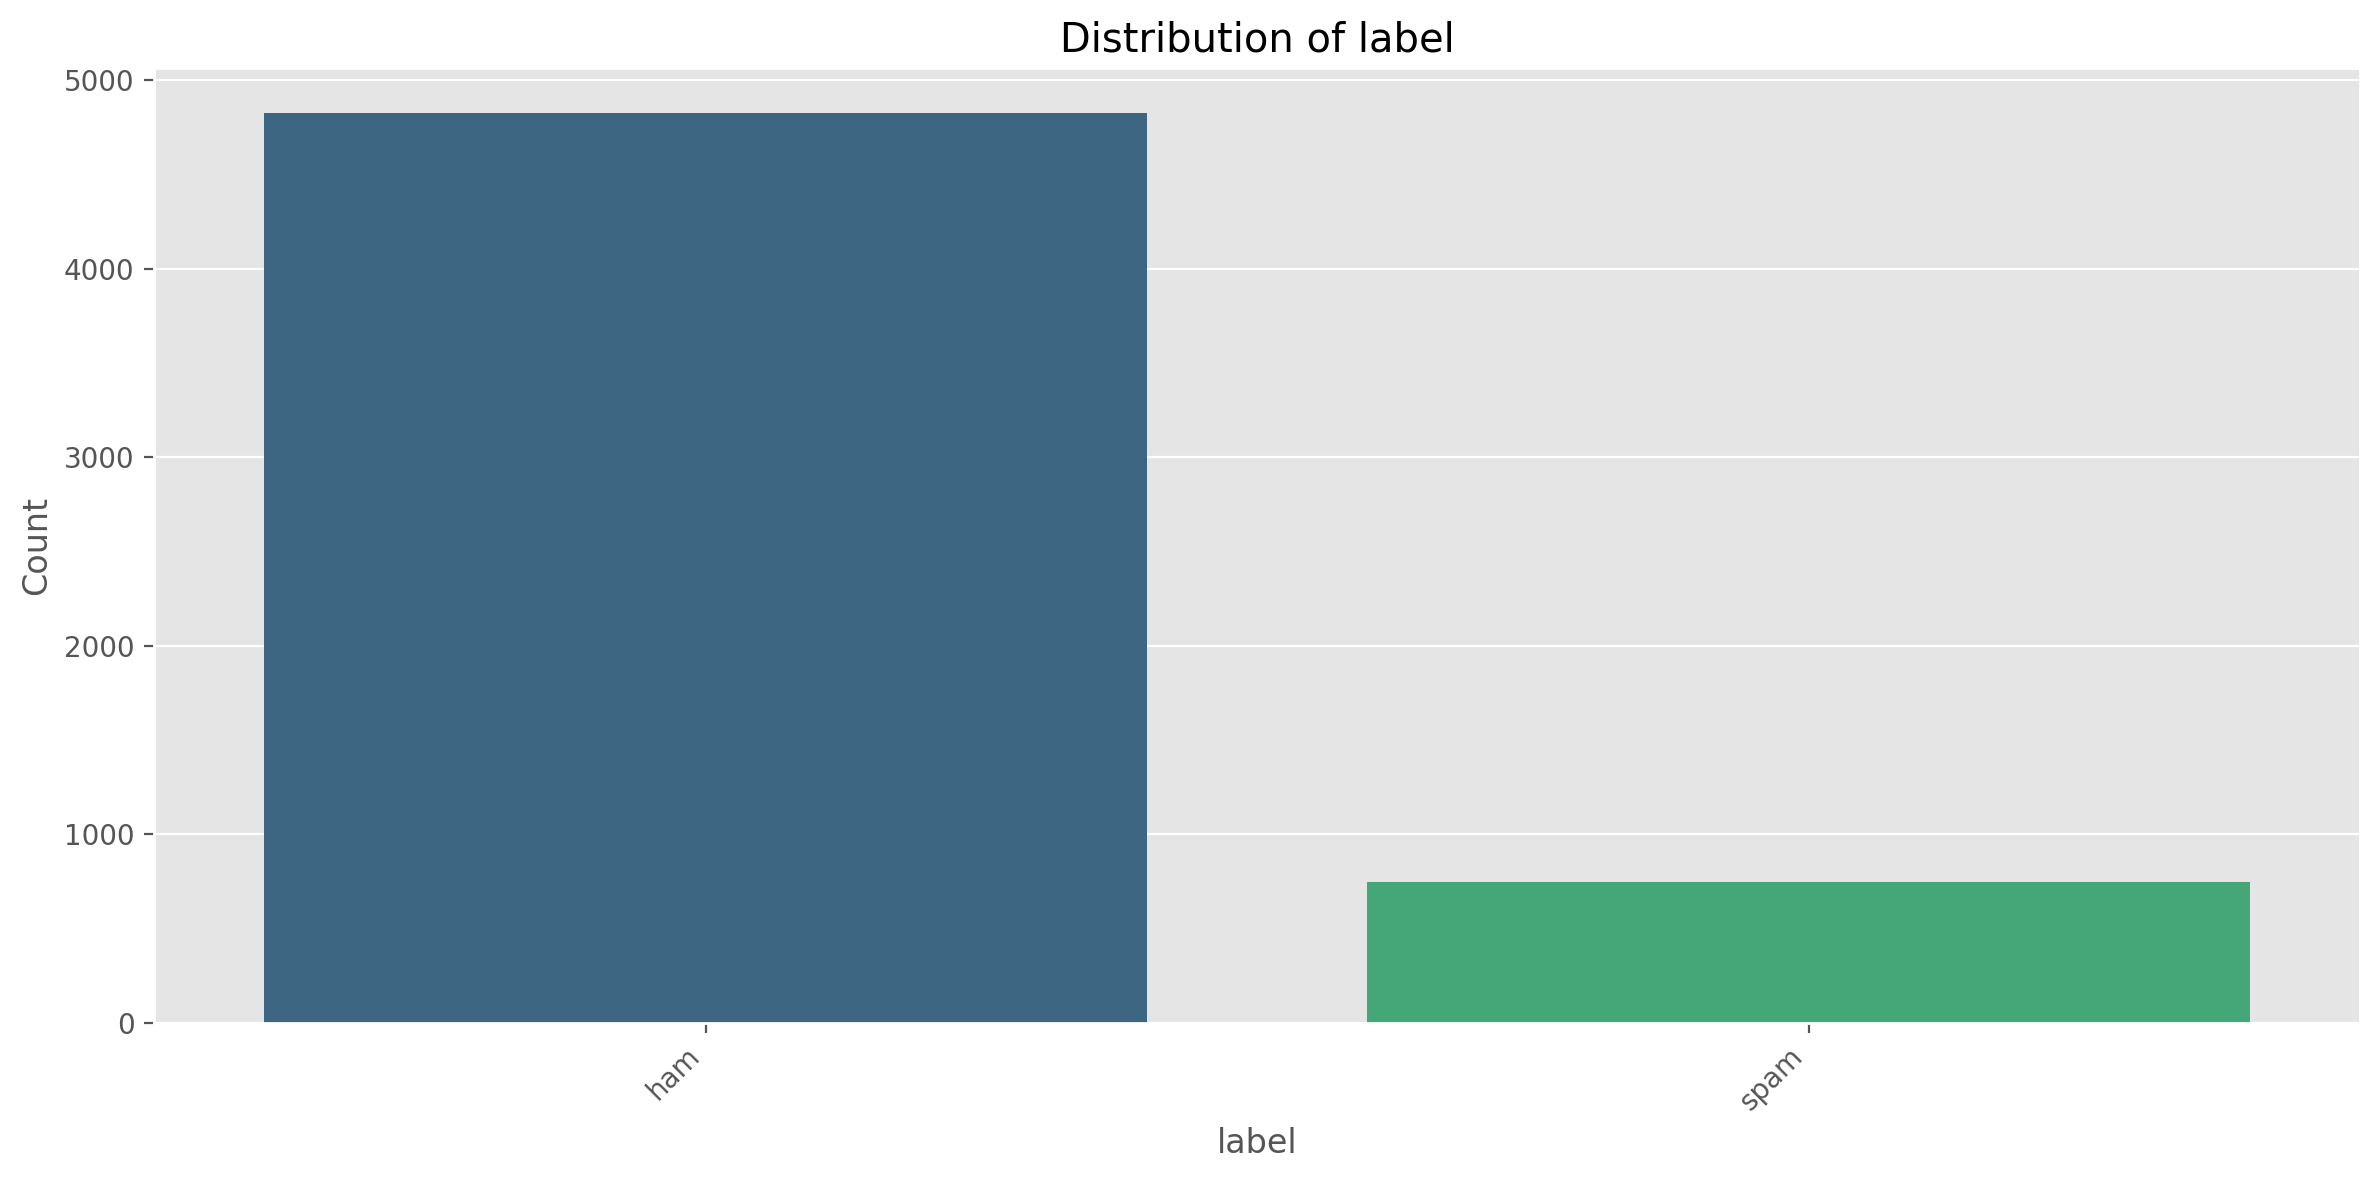

In [126]:
plot_value_counts(df, 'label' , color_palette='viridis')

### data being imbalanced 

In [128]:
label_counts = df["label"].value_counts()
percentages = label_counts / len(df) * 100
print(percentages)

label
ham     86.593683
spam    13.406317
Name: count, dtype: float64


## Dataset Balancing

### filtering out data which are ham to another dataset

In [131]:
ham = df[df['label']=='ham']
ham.shape

(4825, 4)

In [132]:
ham.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2
6,ham,Even my brother is not like to speak with me. ...,77,2


In [133]:
spam = df[df['label']=='spam']  ### similar to above 
spam.shape

(747, 4)

**`ham = ham.sample(spam.shape[0])`**

This line of code performs a **random undersampling** of the `ham` DataFrame. 

It selects a random subset of rows from `ham`, where the number of rows in this subset is equal to the number of rows in the `spam` DataFrame. 


In [135]:
ham = ham.sample(spam.shape[0])


In [136]:
ham.shape

(747, 4)

In [137]:
import re

def extract_features(df):
    df['has_link'] = df['message'].str.contains(r'http|www|\.com|\.ru|\[link\]', regex=True).astype(int)
    df['has_money'] = df['message'].str.contains(r'\$\d+', regex=True).astype(int)
    df['has_urgent_words'] = df['message'].str.contains(r'urgent|required|immediately|clearance|customs|win', case=False, regex=True).astype(int)
    return df

data = extract_features(data)

In [138]:
data = pd.concat([ham, spam], axis=0, ignore_index=True)
data.shape

(1494, 4)

In [139]:
data.sample(10)

,label,message,length,punct
602,ham,K.. I yan jiu liao... Sat we can go 4 bugis vi...,155,10
814,spam,okmail: Dear Dave this is your final notice to...,161,5
1047,spam,FreeMsg: Hey - I'm Buffy. 25 and love to satis...,154,7
1139,spam,Adult 18 Content Your video will be with you s...,52,0
219,ham,Wish u many many returns of the day.. Happy bi...,60,4
1472,spam,You have 1 new message. Call 0207-083-6089,42,3
95,ham,Then get some cash together and I'll text jason,47,1
688,ham,Not course. Only maths one day one chapter wit...,75,2
1474,spam,You have won a guaranteed 32000 award or maybe...,162,12
54,ham,Webpage s not available!,24,1


### Exploratory Data Analysis


In [141]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 4)
plt.style.use('ggplot')

In [142]:
ham.columns


Index(['label', 'message', 'length', 'punct'], dtype='object')

In [143]:
spam.columns

Index(['label', 'message', 'length', 'punct'], dtype='object')

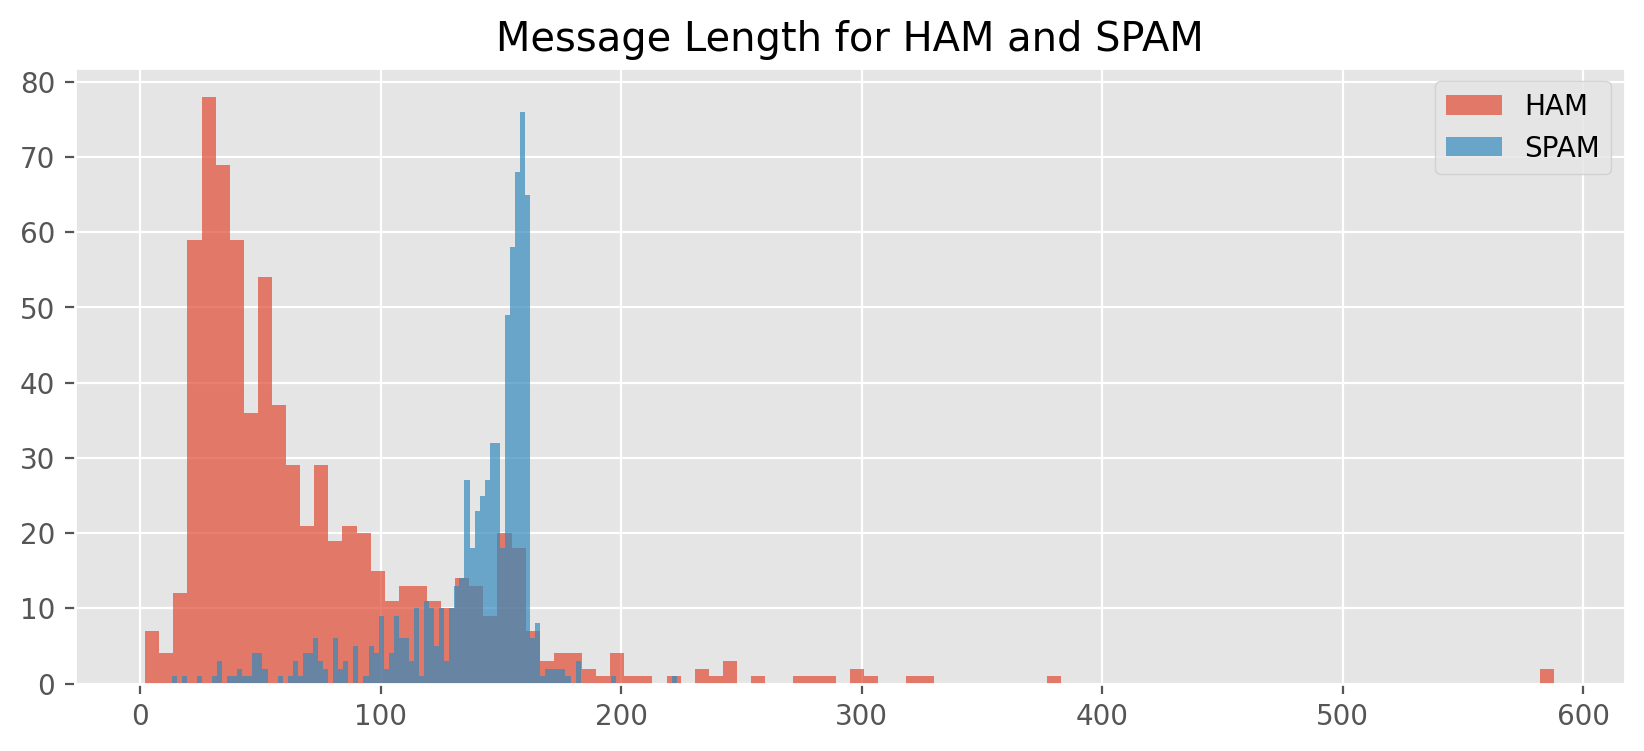

In [144]:
plt.hist(ham['length'], bins=100, alpha=0.7, label='HAM')
plt.hist(spam['length'], bins=100, alpha=0.7, label='SPAM')
plt.title('Message Length for HAM and SPAM')
plt.legend()
plt.show()

In [145]:
df[(df['label'] == 'spam') & (df['length'] > 200)]


,label,message,length,punct
1734,spam,"Hi, this is Mandy Sullivan calling from HOTMIX...",223,16


In [146]:
pd.set_option('display.max_colwidth', None)
spam_over_200 = df[(df['label'] == 'spam') & (df['length'] > 200)]
print(spam_over_200['message'])


1734    Hi, this is Mandy Sullivan calling from HOTMIX FM...you are chosen to receive £5000.00 in our Easter Prize draw.....Please telephone 09041940223 to claim before 29/03/05 or your prize will be transferred to someone else....
Name: message, dtype: object


### reset the global option :


In [148]:
pd.reset_option('display.max_colwidth')

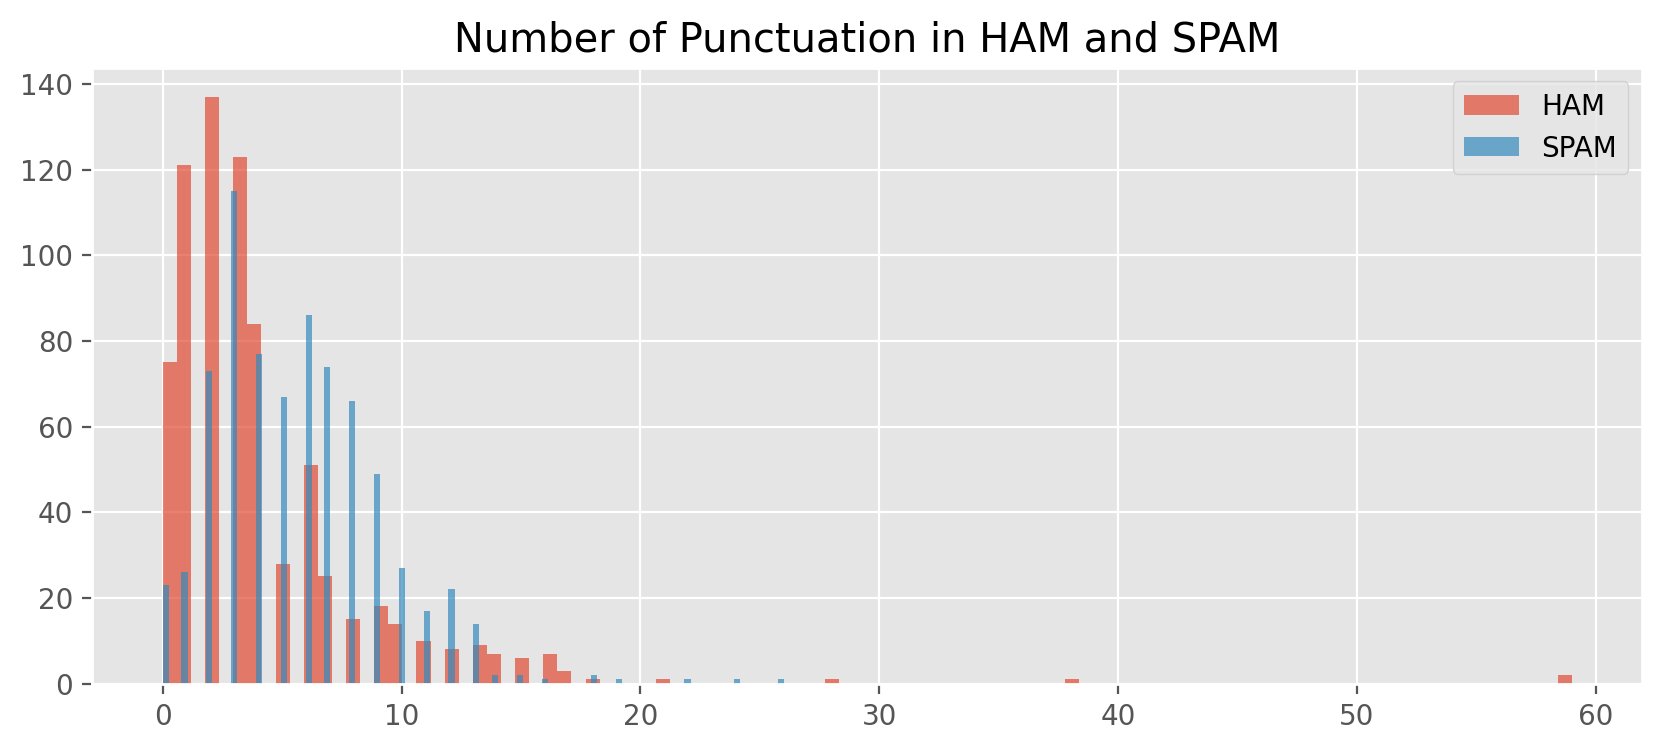

In [149]:
plt.hist(ham['punct'], bins=100, alpha=0.7, label='HAM')
plt.hist(spam['punct'], bins=100, alpha=0.7, label='SPAM')
plt.title('Number of Punctuation in HAM and SPAM')
plt.legend()
plt.show()

 * **X-axis:** Represents the **Number of Punctuation Marks** present in each text message. The horizontal scale shows the count of punctuation characters (e.g., 0, 5, 10, 20, etc.). Each bar along this axis corresponds to a bin representing a range of these counts.

* **Y-axis:** Represents the **Frequency or Count of Messages**. The vertical scale indicates how many messages (either 'HAM' or 'SPAM') have a punctuation count that falls within the range of the corresponding bin on the X-axis.


In [174]:
print(data.columns)

Index(['label', 'message', 'length', 'punct', 'has_link', 'has_money',
       'has_urgent_words'],
      dtype='object')


In [172]:
data = extract_features(data)

### Data Preparation for Training


In [176]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  #RandomForest (ensemble)


In [178]:
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


### input data - data['message']
### target output - data['label']

In [181]:
X = data[['message', 'has_link', 'has_money', 'has_urgent_words']]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y
)

X_train.shape, X_test.shape

((1195, 4), (299, 4))

### model Building


In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

### Transformer for text and numeric features


In [187]:
preprocessor = ColumnTransformer([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english'), 'message'),
    ('scaler', StandardScaler(), ['has_link', 'has_money', 'has_urgent_words'])
])


### Pipeline with preprocessing + model


In [190]:
clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'message'),
                                                 ('scaler', StandardScaler(),
                                                  ['has_link', 'has_money',
                                                   'has_urgent_words'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [192]:
y_pred = clf.predict(X_test)

In [194]:
print(classification_report(y_test, y_pred))

## y_test - true value 
## y_pred - predicted value

              precision    recall  f1-score   support

         ham       0.88      0.96      0.92       150
        spam       0.96      0.87      0.91       149

    accuracy                           0.91       299
   macro avg       0.92      0.91      0.91       299
weighted avg       0.92      0.91      0.91       299



In [209]:
test_msg = 'Congratulations! You have been selected as a lucky winner in our online draw. To claim your $1,000,000 prize, please provide your bank account details and a processing fee of $20.'

test_df = pd.DataFrame({'message': [test_msg]})

# Extract the same features as in training
test_df = extract_features(test_df)

# Make prediction
prediction = clf.predict(test_df[['message', 'has_link', 'has_money', 'has_urgent_words']])
print(prediction)

['spam']


### available classes

In [212]:
clf.classes_

array(['ham', 'spam'], dtype=object)

## Save and Load Model


In [215]:
import pickle
pickle.dump(clf, open('model.pkl', 'wb'))

In [217]:
model = pickle.load(open('model.pkl', 'rb')) ## load

### rb , read in binary mode

In [229]:
test_msg = "Hey babe xoxo miss you! Check out my pics here: hotlink.ru"
#test_msg = "URGENT! You've won a free iPhone 15! Click the link now before it expires!"

#test_msg = ' hi my name is jonathan , great to see you '

test_df = pd.DataFrame({'message': [test_msg]})

test_df = extract_features(test_df)

prediction = model.predict(test_df[['message', 'has_link', 'has_money', 'has_urgent_words']])
print(prediction)

['spam']


In [231]:
test_msg = ' hi my name is jonathan , great to see you '
test_df = pd.DataFrame({'message': [test_msg]})
test_df = extract_features(test_df)
prediction = model.predict(test_df[['message', 'has_link', 'has_money', 'has_urgent_words']])
print(prediction)

['ham']
